# DC2 Coadd Run1.1p GCR tutorial -- Part III: Guided Challenges

Owners: **Javier Sanchez [@fjaviersanchez](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@fjaviersanchez), Francois Lanusse [@EiffL](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@EiffL)**  
Last Run: **2018-07-16**

This notebook is the last in the Run1.1p GCR series ([Part I](DC2%20Coadd%20Run1.1p%20GCR%20tutorial%20--%20Part%20I%3A%20GCR%20Access.ipynb), [Part II](DC2%20Coadd%20Run1.1p%20GCR%20tutorial%20--%20Part%20II%3A%20Lensing%20Cuts.ipynb)). Here, we propose some challenges for you as science use cases of the coadd catalogs. We will provide a solution here but you are encouraged to create your own!


__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Challenge 1: Galaxy counts-in-cells

Blending affects the accuracy of centroid and flux measurements. It can potentially generate a systematic effect in different measurements (for example 2-point statistics). 

The stack, returns a very useful value to check (partially) for the presence of these kind of systematics, which is the `blendedness` parameter (more details on Section 4.9.11 of [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf)

* Q: Why only partially?


A very simple tool to measure the different statistical moments of galaxies is Counts-in-cells (CiC) [Peebles et al. 1980](https://press.princeton.edu/titles/724.html). Here, we are going to use a simplified version of CiC to check the possible systematic effects due to differences in the `blendedness` measurements.

So what's CiC?

1) Count the number of galaxies in a cell of a given scale.

2) Measure the density contrast distribution and its moments.

3) Change the scale and repeat.

Note: We are focusing on the galaxy number CiC but it is possible to do with shapes

In [2]:
from cic import cic_analysis

In [3]:
import healpy as hp

In [4]:
import GCRCatalogs
from GCR import GCRQuery
# Load the coadd catalog
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [5]:
# Let's use almost the same cuts as in the WL sample
tract_number = 4849
cic_cuts_nb = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness < 10**(-0.375)'),
]

cic_cuts_b = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness > 10**(-0.375)'),
]

quantities = ['ra','dec']
d_nb = catalog.get_quantities(quantities, 
                           filters=cic_cuts_nb, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
d_b = catalog.get_quantities(quantities, 
                           filters=cic_cuts_b, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:227: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:227: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


In [6]:
m10map = hp.read_map('assets/DC2_10sigma_depth.fits.gz') # This is the 10 sigma map 
mask = np.zeros_like(m10map)
mask[m10map>23.0] = 1.0

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


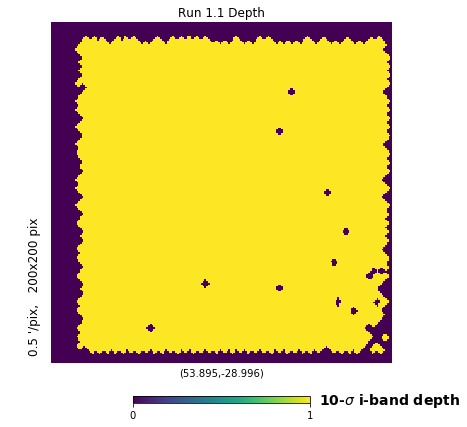

In [7]:
hp.gnomview(mask,rot=(d_nb['ra'].mean(), d_nb['dec'].mean()), title='Run 1.1 Depth', reso=0.5,unit='10-$\sigma$ i-band depth')

In [8]:
sigma_b, sigma_err_b, skw_b, skw_err_b, kurtosis_b, kurtosis_err_b, pixel_scale = cic_analysis(d_b, mask, nboot=100)
sigma_nb, sigma_err_nb, skw_nb, skw_err_nb, kurtosis_nb, kurtosis_err_nb, _  = cic_analysis(d_nb, mask, nboot=100)

/global/u2/p/pjm43/desc/DC2_Repo/Notebooks/.beavis/DC2_Repo/Notebooks/cic.py:55: RuntimeWarning: invalid value encountered in double_scalars
  avdens = Ngal/(1.0*Npix)/hp.nside2pixarea(nside)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


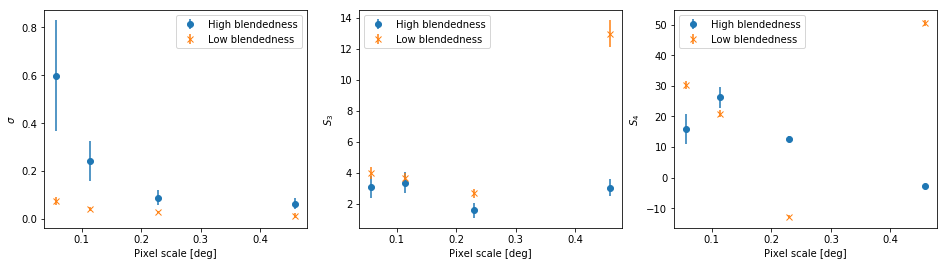

In [9]:
f, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].errorbar(pixel_scale, sigma_b, sigma_err_b, fmt='o', linestyle='none', label='High blendedness')
ax[0].errorbar(pixel_scale, sigma_nb, sigma_err_nb, fmt='x', linestyle='none', label='Low blendedness')
ax[0].legend()
ax[0].set_xlabel('Pixel scale [deg]')
ax[0].set_ylabel(r'$\sigma$')
ax[1].errorbar(pixel_scale, skw_b, skw_err_b, fmt='o', linestyle='none', label='High blendedness')
ax[1].errorbar(pixel_scale, skw_nb, skw_err_nb, fmt='x', linestyle='none', label='Low blendedness')
ax[1].legend()
ax[1].set_xlabel('Pixel scale [deg]')
ax[1].set_ylabel(r'$S_{3}$')
ax[2].errorbar(pixel_scale, kurtosis_b, kurtosis_err_b, fmt='o', linestyle='none', label='High blendedness')
ax[2].errorbar(pixel_scale, kurtosis_nb, kurtosis_err_nb, fmt='x', linestyle='none', label='Low blendedness')
ax[2].legend()
ax[2].set_xlabel('Pixel scale [deg]')
ax[2].set_ylabel(r'$S_{4}$')

There's definitely something going on with the high blendedness sources!

## Challenge 2: Check if PSF residuals are within requirements

In this section, we will try to apply all the tools we have covered during this tutorial to test the quality of the DM stack PSF model on run 1.1p.

The challenge will be to select a clean sample of stars, compute their size and ellipticity using second moments, and compare those to the PSF model predicted by the DM stack. We will test the one point and two point fuctions of these residuals to make diagnostic plots that would directly go into a weak lensing shape catalog paper.

==TODO==: A few words about second moments ?

### Step 1: Select a clean sample of point sources

We want to restrict our sample to objects that follow these constraints:
 - Point sources
 - Not corrupted or with any defects
 - Successful second moment measurements
 - Sufficiently high signal to noise in the i-band, above 50
 
Remember to use [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) as a reference to build your cuts

In [10]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

filters=[
    #### This would be removed in the tutorial notebook
         GCRQuery('extendedness == 0'),
         GCRQuery('clean'), 
         GCRQuery('blendedness < 10**(-0.375)'),
        ~GCRQuery('I_flag'),
         GCRQuery('i_SNR > 21')
    ####
]

### Step 2: Computes size and ellipticity from second moments

We will use the following definitions:  
$g_1 = \frac{I_{xx} - I_{yy}}{I_{xx} + I_{yy}}$  
$g_2 = \frac{2 I_{xy}}{I_{xx} + I_{yy}}$  
$\sigma = ( I_{xx} I_{yy} - I_{xy}^2)^{1/4}$ 

Using the `add_modifier_on_derived_quantities` of the GCR (documented [here](https://yymao.github.io/generic-catalog-reader/index.html#GCR.BaseGenericCatalog.add_modifier_on_derived_quantities)), add modifiers to compute these quantities for the sources and the PSF model evaluated at the position of the sources.
Again the schema is your friend ;-)

In [11]:
# This would be hiddden #$####
g1_modif = lambda ixx,iyy,ixy: (ixx-iyy)/(ixx+iyy)
g2_modif = lambda ixx,iyy,ixy:  2.*ixy/(ixx+iyy)
sigma_modif = lambda ixx,iyy,ixy: (ixx*iyy - ixy**2)**0.25
#######

# Here is a template to fill for g1
catalog.add_modifier_on_derived_quantities('g1',
                                           #### This would be removed in the tutorial
                                           g1_modif, 
                                           'Ixx', 'Iyy', 'Ixy'
                                           ########
                                          )
# Define in the same way g2, sigma, psf_g1, psf_g2 psf_sigma

### The following would be hidden
catalog.add_modifier_on_derived_quantities('g2', g2_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('sigma', sigma_modif, 'Ixx', 'Iyy', 'Ixy')

catalog.add_modifier_on_derived_quantities('psf_g1', g1_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_g2', g2_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_sigma', sigma_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')

### Step 3: Extract sample

Now that we have all the pieces, let's extract the quantities specified below from the catalog:

In [12]:
quantities = ['ra', 'dec', 
              'mag_i', 'i_SNR', 'psf_fwhm_i',
              'g1', 'g2', 'sigma',
              'psf_g1', 'psf_g2', 'psf_sigma']

# Would be hidden
data = catalog.get_quantities(quantities, 
                              native_filters=[(lambda x: x==4850, 'tract')],
                              filters=filters)

### Step 4: Size and ellipticity residuals as a function of magnitude and seeing

Try to reproduce plots similar to the ones you can find in the PSF section of your favorite experiment's shape catalog paper (for instance Section 4. of [Mandelbaum et al. 2017](https://arxiv.org/pdf/1705.06745.pdf)).

For instance you can look at the fractional difference in size, as a function of magnitude, or seeing. You can also look at the distribution of ellipticity residuals, make sure they are centered on 0 , and again see if you can spot a dependence on seeing or magnitude.

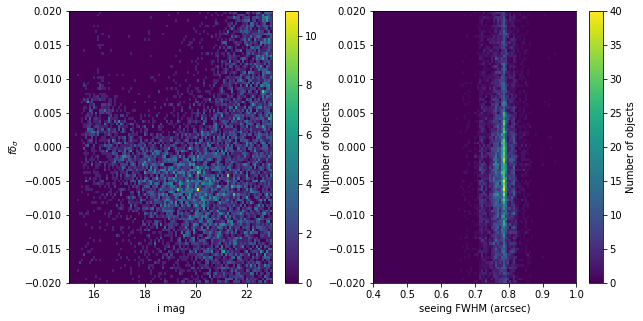

In [13]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.hist2d(data['mag_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[15,23],[-0.02,0.02]]);
plt.xlabel('i mag')
plt.ylabel('$f \delta_\sigma$')
plt.colorbar(label='Number of objects')
plt.subplot(122)
plt.hist2d(data['psf_fwhm_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[0.4,1.0],[-0.02,0.02]]);
plt.xlabel('seeing FWHM (arcsec)')
plt.colorbar(label='Number of objects');

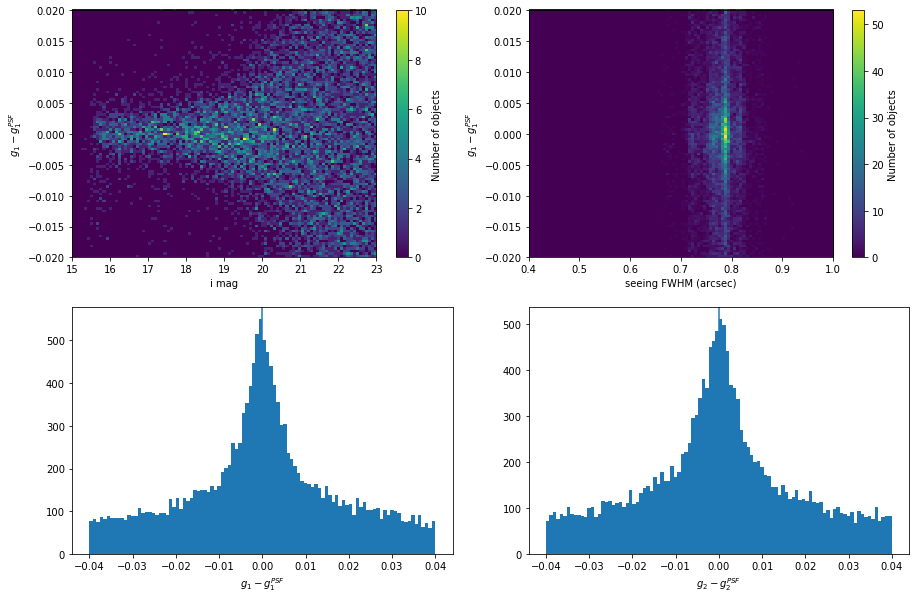

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.hist2d(data['mag_i'], (data['g1'] - data['psf_g1']), 100, range=[[15,23],[-0.02,0.02]]);
plt.xlabel('i mag')
plt.ylabel('$g_1 - g_1^{PSF}$')
plt.colorbar(label='Number of objects')
plt.subplot(222)
plt.hist2d(data['psf_fwhm_i'], (data['g1'] - data['psf_g1']), 100, range=[[0.4,1.0],[-0.02,0.02]]);
plt.xlabel('seeing FWHM (arcsec)')
plt.ylabel('$g_1 - g_1^{PSF}$')
plt.colorbar(label='Number of objects')
plt.subplot(223)
plt.hist((data['g1'] - data['psf_g1']), 100, range=[-0.04,0.04]);
plt.xlabel('$g_1 - g_1^{PSF}$')
plt.axvline(0)
plt.subplot(224)
plt.hist((data['g2'] - data['psf_g2']), 100, range=[-0.04,0.04]);
plt.xlabel('$g_2 - g_2^{PSF}$')
plt.axvline(0)

### Step 5: Compute $\rho$-statistics in Stile

No shear catalog paper would be complete without the so-called $\rho$-statistics (Rowe, Jarvis), which check the two-point correlations of the PSF residuals.

==TODO==: Add more details and proper reference !


We are going to use the [Stile](https://github.com/msimet/Stile) package developed by Melanie Simet [@msimet](https://github.com/msimet), an incredibly useful package which already implements a range of WL related systematics tests, including the $\rho$ statistics. Checkout the documentation for Stile [here](http://stile.readthedocs.io/en/latest/index.html).

In [15]:
import pandas
import stile

# Stile expects numpy structured arrays, here is an easy way to do that:
d = pandas.DataFrame(data)
# We also add a weight column, set to 1
d['w'] =1
d = d.to_records(index=False)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [16]:
# Here is an example of how to compute the rho1 statistics
stile_args = {'ra_units': 'degrees', 'dec_units': 'degrees',
              'min_sep': 0.05, 'max_sep': 1, 'sep_units': 'degrees', 'nbins': 20}

rho1 = stile.CorrelationFunctionSysTest('Rho1')

r1 = rho1(d, config=stile_args)

In [17]:
# Have a look at the content of the result array
r1

array([ ( 0.053888,  0.054138, -2.9172  ,  -6.86960000e-06,  -1.12120000e-05,   8.44320000e-06,   2.83490000e-06,   7.28750000e-06,    476870.,    476870.),
       ( 0.062596,  0.062872, -2.7676  ,   9.22840000e-06,   1.05170000e-05,  -6.17390000e-06,  -9.94910000e-06,   6.30810000e-06,    636450.,    636450.),
       ( 0.072711,  0.073027, -2.6179  ,   5.87670000e-06,   3.14390000e-06,   6.04370000e-06,  -6.23720000e-06,   5.48250000e-06,    842570.,    842570.),
       ( 0.08446 ,  0.084835, -2.468   ,  -1.98500000e-06,   1.52450000e-06,   3.99510000e-06,  -3.77170000e-06,   4.75960000e-06,   1118000.,   1118000.),
       ( 0.098107,  0.098529, -2.3183  ,   3.49930000e-06,  -5.00390000e-06,   1.02920000e-06,  -6.89440000e-06,   4.13280000e-06,   1482700.,   1482700.),
       ( 0.11396 ,  0.11446 , -2.1684  ,  -2.84450000e-06,  -5.12910000e-06,   3.55620000e-06,   5.21860000e-06,   3.59880000e-06,   1955400.,   1955400.),
       ( 0.13237 ,  0.13295 , -2.0187  ,   1.43890000e-06,   4.

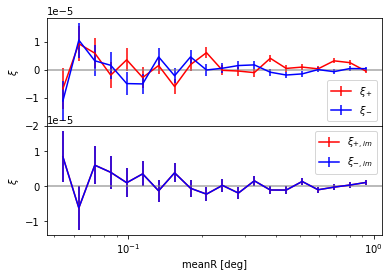

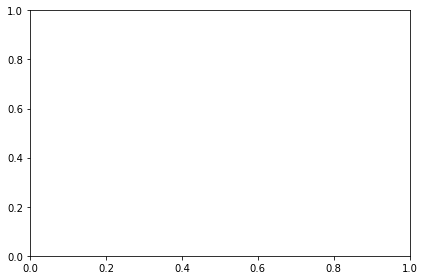

In [18]:
# Stile offers utility functions to generate 
f = rho1.plot(r1)

In [19]:
rho1 = stile.CorrelationFunctionSysTest('Rho1')
rho2 = stile.CorrelationFunctionSysTest('Rho2')

r1 = rho1(d, config=stile_args)
r2 = rho2(d, config=stile_args)

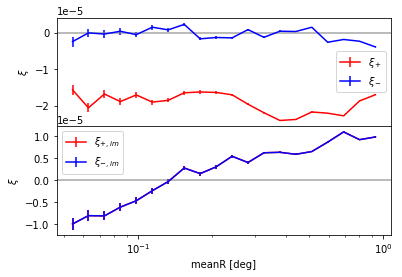

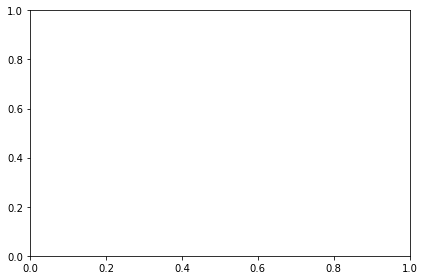

In [20]:
f = rho2.plot(r2);